Universidad Galileo

Statistical Learning II

PAPD - Sección V

Sergio José Barrios Martínez

Carnet No. 19012765

## Práctica No. 1

### Parte No. 2: Anomaly Detection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from scipy.stats import multivariate_normal

### Entrenamiento con Distribución Normal Multivariada

Se leen los datos de entrenamiento desde CSV. Los datos de entrenamiento no contienen anomalías, ya que se quiere entrenar sobre el conjunto de datos normales.

In [2]:
df_entrenamiento = pd.read_csv('training_anomaly.csv')
df_entrenamiento = df_entrenamiento[["Edad","Estatura"]]
df_entrenamiento

,Edad,Estatura
0,26,1.77
1,31,1.74
2,24,1.72
3,34,1.78
4,32,1.65
5,29,1.66
6,27,1.64
7,34,1.85
8,26,1.85
9,21,1.75


#### Estimación de Parámetros de Distribución Multivariada (Vector de Medias y Matriz de Covarianza)

Se utilizará la función de Distribución Multivariada para estimar la PDF del conjunto de entrenamiento.
Para ello se definirán dos funciones:
- Determinación de Parámetros de PDF Multivariada (media y covarianza).
- Determinación de PDF Multivariada (con multivariate_normal).


In [3]:
def estimacion_normal(datos):
    medias = np.mean(datos, axis = 0)
    covarianza = np.cov(datos.T)
    return medias,covarianza

In [4]:
def distribucion_multivariada(datos,medias,covarianza):
    probabilidades = multivariate_normal(mean=medias,cov=covarianza)
    return probabilidades.pdf(datos)

Parámetros de Distribución Multivariada

In [5]:
medias_entrenamiento,covarianza_entrenamiento= estimacion_normal(df_entrenamiento)
print("Medias:")
print(medias_entrenamiento)
print("Matriz de Covarianza:")
print(covarianza_entrenamiento)

Medias:
Edad        28.310345
Estatura     1.734483
dtype: float64
Matriz de Covarianza:
[[2.19359606e+01 2.71305419e-02]
 [2.71305419e-02 6.11133005e-03]]


Distribución Multivariada (considerando posibles correlaciones entre Edad y Estatura)

In [6]:
pdf_multivariada = distribucion_multivariada(df_entrenamiento,medias_entrenamiento,covarianza_entrenamiento)
pdf_multivariada

array([0.34191419, 0.36947513, 0.2834394 , 0.18450539, 0.16646052,
       0.2703258 , 0.20619402, 0.07915274, 0.12186773, 0.12268719,
       0.22911876, 0.25347203, 0.14473511, 0.19952848, 0.25347203,
       0.20061665, 0.35546521, 0.04090768, 0.25306917, 0.40914669,
       0.29537546, 0.01561441, 0.10464836, 0.14473511, 0.05122697,
       0.20614432, 0.02555203, 0.41157343, 0.33306881])

### Validación y Determinación de Epsilon

Para poder estimar el valor del umbral ***$\epsilon$ Epsilon*** (que determina la probabilidad debajo de la cual se considerará una observación como anomalía) se utilizará un conjunto de validación. Este conjunto tiene observaciones **normales** y observaciones que sabemos que son **anómalas**, por lo tanto se incluye también su etiqueta (ground truth) con Y = 0 en el caso normal, Y = 1 en el caso anormal.

In [7]:
df_validacion = pd.read_csv('validation_anomaly.csv')
x_validacion = df_validacion[["Edad","Estatura"]]
y_validacion = df_validacion[["Anomalia"]]

df_validacion

,Estatura,Edad,Anomalia
0,1.82,25.0,0
1,1.80,27.0,0
2,1.60,31.0,0
3,1.60,35.0,0
4,0.25,2.4,1
5,175.10,2.5,1


Encontramos entonces la PDF multivariada utilizando la función **multivariate_normal**, basándonos en los parámetros de entrenamiento encontrados (medias y matriz de covarianza):

In [8]:
pdf_validacion = distribucion_multivariada(x_validacion,medias_entrenamiento,covarianza_entrenamiento)
pdf_validacion

array([1.75382599e-01, 2.89286696e-01, 7.74871753e-02, 2.93934007e-02,
       4.19416801e-83, 0.00000000e+00])

Función para seleccionar Epsilon, en función de la métrica de validación F1-Score. Para ello se envía la PDF de validación encontrada con anterioridad, y las etiquetas correspondientes (ground truth).

In [9]:
def seleccion_Epsilon(pdf,etiquetas):
    mejor_epsilon = 0
    mejor_f1 = 0
    f1 = 0
    f1_scores = []

    
    tamaño_paso = (max(pdf) - min(pdf))/1000 # Tamaño del paso: rango de la pdf dividido por 1000
    epsilons = np.arange(min(pdf),max(pdf),tamaño_paso) # Prueba de 1000 Epsilons
    
    # Examen sobre todos los valores de Epsilon
    for epsilon in epsilons:
        predicciones = (pdf < epsilon)
        f1 = f1_score(etiquetas,predicciones,average="binary")
        f1_scores = np.append(f1_scores,f1)
        if f1 > mejor_f1:
            mejor_f1 = f1
            mejor_epsilon = epsilon
    
    
    # Progreso F1-Score vrs. Epsilon
    plt.scatter(epsilons, f1_scores,c='purple',s=10)
    plt.title('F1-Score vrs. Epsilon')
    plt.xlabel('Epsilon')
    plt.ylabel('F1-Socre')
    plt.show()
    
    return mejor_f1,mejor_epsilon


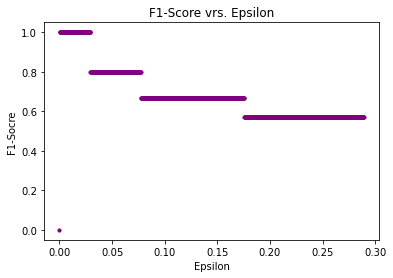

In [10]:
mejor_f1,mejor_epsilon = seleccion_Epsilon(pdf_validacion,y_validacion)

In [11]:
mejor_epsilon

0.000289286695661907

In [12]:
mejor_f1

1.0

### Predicción en Conjunto de Pruebas TEST

In [13]:
df_pruebas = pd.read_csv('test_anomaly.csv')
df_pruebas = df_pruebas [["Edad","Estatura"]]
df_pruebas

,Edad,Estatura
0,30,1.82
1,32,1.76
2,31,1.79
3,31,1.61
4,250,0.15
5,14,150.00


In [14]:
def prediccion_anomalias(df,epsilon,mu_entrenamiento,sigma_entrenamiento):
    
    df_salida = df.copy()
    f1 = 0
    observaciones = df_pruebas.shape[0]
    predicciones = np.zeros(observaciones)
    
    # Para el conjunto de pruebas, calculamos su PDF basado en los
    # parámetros de medias y covarianza del entrenamiento
    pdf = distribucion_multivariada(df,mu_entrenamiento,sigma_entrenamiento)  
    predicciones = (pdf < epsilon)
    
    df_salida["Anomalia"] = predicciones
    
    return df_salida
    

In [15]:
prediccion_anomalias(df_pruebas,mejor_epsilon,medias_entrenamiento,covarianza_entrenamiento)

,Edad,Estatura,Anomalia
0,30,1.82,False
1,32,1.76,False
2,31,1.79,False
3,31,1.61,False
4,250,0.15,True
5,14,150.00,True
